# Table of Contents
- [Imports](#Import)
- [Data Read In](#Data-Read-In)
- [Hierarchical GLM](#Hierarchical-GLM)
- [Running Bambi Model](#Running-Bambi-Model)

# Imports
[back to top](#Table-of-Contents)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from bambi import Model, Prior
import pymc3 as pm
import pickle

# Data Read In
[back to top](#Table-of-Contents)

In [11]:
root = "../data/"
survNoNA = (pd.read_csv(root+"survCleanWithSameCols.csv", index_col=0).sort_values(["year", "sitecode"])
              .drop(['race7', 'stheight', 'stweight', 'qnobese'], axis=1))
survSomeNA = pd.read_csv(root+"survCleanWithSomeNA.csv", index_col=0).sort_values(["year", "sitecode"])
surv2017 = pd.read_csv(root+"survSomeNA2017.csv")
survNoNA.head()

,carRiskScore,sitecode,year,age,sex,grade,race4,bmi,qnowt,q13,q18,q25,q26,q47,q57
122833,78.947368,CH,2005,1.0,2.0,1.0,2.0,22.401235,1.0,1.0,1.0,1.0,2.0,1.0,1.0
122834,0.000000,CH,2005,3.0,2.0,1.0,2.0,29.518950,2.0,1.0,1.0,1.0,1.0,1.0,1.0
122836,105.263158,CH,2005,3.0,2.0,1.0,2.0,19.041156,2.0,1.0,1.0,2.0,2.0,1.0,2.0
122839,157.894737,CH,2005,3.0,2.0,1.0,2.0,19.470395,2.0,1.0,1.0,2.0,2.0,1.0,1.0
122840,0.000000,CH,2005,3.0,2.0,1.0,4.0,22.045828,2.0,1.0,1.0,2.0,2.0,2.0,2.0


In [3]:
survNoNA.query("year == 2017")["sitecode"].value_counts()

DU    1949
FW    1780
SA    1565
MM    1526
SF    1414
CH     883
ST     875
PH     834
OL     774
FT     521
Name: sitecode, dtype: int64

<AxesSubplot:xlabel='index', ylabel='carRiskScore'>

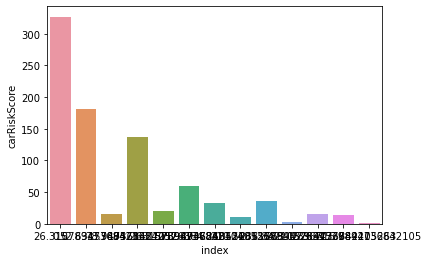

In [4]:
percent98 = survNoNA.carRiskScore.quantile(.98)
sns.barplot(x="index", y="carRiskScore",
            data=survNoNA.query("carRiskScore < @percent98 & year == 2017 & sitecode == 'CH'").carRiskScore.value_counts().to_frame().reset_index())

In [5]:
survSomeNA.head()

,age,bmi,grade,q13,q18,q25,q26,q47,q57,qnobese,...,q32,q69,q46,q19,q12,q8,q9,q41,q40,q27
122831,6.0,NaN,3.0,1.0,1.0,2.0,2.0,1.0,2.0,NaN,...,1.0,1.0,1.0,NaN,1.0,3.0,1.0,1.0,1.0,2.0
122832,NaN,18.048443,1.0,1.0,1.0,2.0,2.0,6.0,2.0,NaN,...,3.0,1.0,4.0,2.0,5.0,4.0,4.0,2.0,5.0,2.0
122833,1.0,22.401235,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,...,1.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0,3.0,2.0
122834,3.0,29.518950,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,7.0,1.0,2.0,3.0,5.0,1.0,1.0,4.0,1.0
122835,3.0,21.520933,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,...,1.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,1.0,2.0


In [9]:
survSomeNA.columns

Index(['age', 'bmi', 'grade', 'q13', 'q18', 'q25', 'q26', 'q47', 'q57',
       'qnobese', 'qnowt', 'race4', 'race7', 'sex', 'stheight', 'stweight',
       'sitecode', 'year', 'q70', 'q50', 'q15', 'q16', 'q17', 'q67', 'q68',
       'q23', 'q51', 'q53', 'q32', 'q69', 'q46', 'q19', 'q12', 'q8', 'q9',
       'q41', 'q40', 'q27'],
      dtype='object')

# Hierarchical GLM
[back to top](#Table-of-Contents)

In [6]:
#generate sample from data just for testing
percent98 = survNoNA.carRiskScore.quantile(.98)
dat = survNoNA.query("carRiskScore < @percent98 & year == 2005").sample(100)
dat.loc[:,"carRiskScore"] = dat["carRiskScore"] + 1
county_idxs, counties = pd.factorize(dat["sitecode"]) # needed for hierarchical model
coords = {
    "county": counties,
    "obs_id": np.arange(len(county_idxs)),
}

In [7]:
with pm.Model(coords=coords) as model:  # model specifications in PyMC3 are wrapped in a with-statement
    
    county_idx = pm.Data("county_idx", county_idxs, dims="obs_id")

    # Data Setup
    X = dat.drop(["carRiskScore", "sitecode"], axis=1)
    X.insert(0, "intercept", 1)
    
    # Defining betas for mu
    mu_est = 0
    for i, q in enumerate(X.columns):
        countyLevel = pm.Normal("betaCounty" + str(i), 1, sigma=10, dims="county")
        q_beta = pm.Normal("beta" + str(i), 1, sigma=10)
        mu_est += (q_beta + countyLevel[county_idx]) * X.iloc[:,i]
    
    # Defining Random Sigma
    countyLevel = pm.Normal("sigCounty", 1, sigma=10, dims="county")
    ySig = pm.Gamma("ySig", mu=100, sigma=1000)
    
    # Define likelihood
    likelihood = pm.Gamma(
        "y",
        mu=mu_est,
        sigma=(ySig + countyLevel[county_idx]),
        observed=dat["carRiskScore"], dims="obs_id")

In [8]:
with model:
    approx = pm.fit(100)

Finished [100%]: Average Loss = 2.8496e+06


In [9]:
with model:
    trace = pm.sample(50, return_inferencedata=True, target_accept=0.9, start=approx.sample()[0])
    ppc = pm.sample_posterior_predictive(trace, var_names=["y"])

/tmp/ipykernel_413/3758159050.py:2: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(50, return_inferencedata=True, target_accept=0.9, start=approx.sample()[0])
Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ySig, sigCounty, beta17, betaCounty17, beta16, betaCounty16, beta15, betaCounty15, beta14, betaCounty14, beta13, betaCounty13, beta12, betaCounty12, beta11, betaCounty11, beta10, betaCounty10, beta9, betaCounty9, beta8, betaCounty8, beta7, betaCounty7, beta6, betaCounty6, beta5, betaCounty5, beta4, betaCounty4, beta3, betaCounty3, beta2, betaCounty2, beta1, betaCounty1, beta0, betaCounty0]


Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 336 seconds.
/home/berlands/anaconda3/envs/STATS507/lib/python3.9/site-packages/pymc3/sampling.py:659: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9969988625167986, but should be close to 0.9. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.021082088410776408, but should be close to 0.9. Try to increase the number of tuning steps.


In [10]:
approx.sample()[0]

{'betaCounty0': array([ 1.77081343,  2.06852194,  1.03437997,  2.46439222,  0.17430158,
         0.74082357,  1.82994663, -0.10523066,  0.35091774, -0.80638581,
         0.45138226,  1.05436013,  1.02175487,  0.91146075,  2.58060414,
         0.70159081]),
 'beta0': 1.6179026052282859,
 'betaCounty1': array([-0.88590687,  1.11489795, -0.22838166,  0.94780975,  1.76441922,
         2.03752778,  0.49952519,  1.67791539,  1.10916432,  0.39622445,
         0.71396688, -0.03084189,  2.49167377,  1.22302984, -0.05309308,
         0.79187429]),
 'beta1': 2.710035239529136,
 'betaCounty2': array([ 0.2281005 ,  0.5384303 ,  1.09134634,  1.74980321,  1.76030146,
         0.74399397, -0.1302518 ,  0.63485408,  1.32725891,  1.70885786,
         0.05850593,  0.93943132,  0.21494546,  0.73031372,  0.76110502,
         0.14038834]),
 'beta2': 1.2906731351748948,
 'betaCounty3': array([ 1.3044748 ,  0.55232879,  1.23370385,  0.16028697,  0.85263337,
         1.11756837,  2.59321176,  0.38480971,  1.35

In [56]:
# (n_jobs, n samples, num of hierarchies)
postDict = trace.to_dict()["posterior"]

for k in postDict.keys():
    postDict[k] = postDict[k].mean(axis=0).mean(axis=0)
postDict

{'betaCounty0': array([ 3.13135868,  2.94601215,  0.44101999,  4.0876769 ,  0.75478446,
         6.50087954,  2.30696455, -0.69971981,  0.34211638,  1.07861782,
         1.49910496,  3.11318964,  3.8555472 ,  0.78310707, -6.68865531,
        -0.55888217]),
 'beta0': -0.5136138447840568,
 'betaCounty1': array([0.98253461, 1.94438917, 1.13121542, 1.29910388, 1.19712015,
        1.42951263, 1.21997831, 1.45402141, 1.03283304, 1.32729526,
        1.2892523 , 1.26247303, 0.96212665, 1.37802054, 0.95842431,
        1.40991014]),
 'beta1': 1.153555969818732,
 'betaCounty2': array([ 4.0561652 , -2.20316529,  0.88603272,  7.18282024,  0.79466513,
         4.80633676,  6.04242348,  1.12766937,  1.57900377,  3.91202057,
        -2.39454316, -0.53805375,  5.8454633 , -1.44519292,  2.34028717,
         2.6888499 ]),
 'beta2': -3.4774953349660818,
 'betaCounty3': array([ 1.39472512, -0.98942828,  1.59315685,  3.49648056,  2.0509267 ,
        -6.21844145,  2.13859753,  4.68792268,  1.52818779, -0.215

In [57]:
with model:
    trace = pm.sample(50, return_inferencedata=True, target_accept=0.9, start=postDict)

/tmp/ipykernel_413/617235338.py:2: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(50, return_inferencedata=True, target_accept=0.9, start=postDict)
Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ySig, sigCounty, beta17, betaCounty17, beta16, betaCounty16, beta15, betaCounty15, beta14, betaCounty14, beta13, betaCounty13, beta12, betaCounty12, beta11, betaCounty11, beta10, betaCounty10, beta9, betaCounty9, beta8, betaCounty8, beta7, betaCounty7, beta6, betaCounty6, beta5, betaCounty5, beta4, betaCounty4, beta3, betaCounty3, beta2, betaCounty2, beta1, betaCounty1, beta0, betaCounty0]


Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 363 seconds.
/home/berlands/anaconda3/envs/STATS507/lib/python3.9/site-packages/pymc3/sampling.py:659: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.27057972989627754, but should be close to 0.9. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.


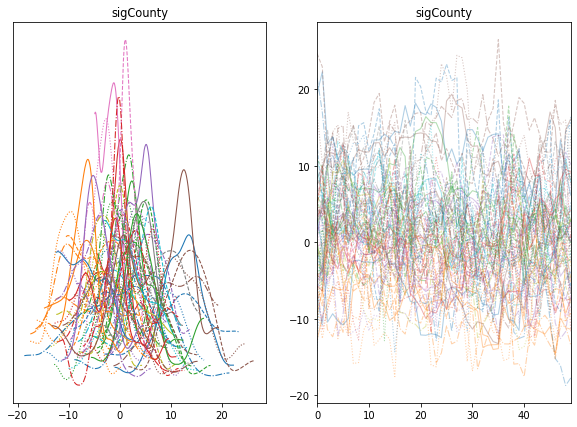

In [88]:
_ = az.plot_trace(trace["posterior"]["sigCounty"][:,:,], figsize=(10, 7))

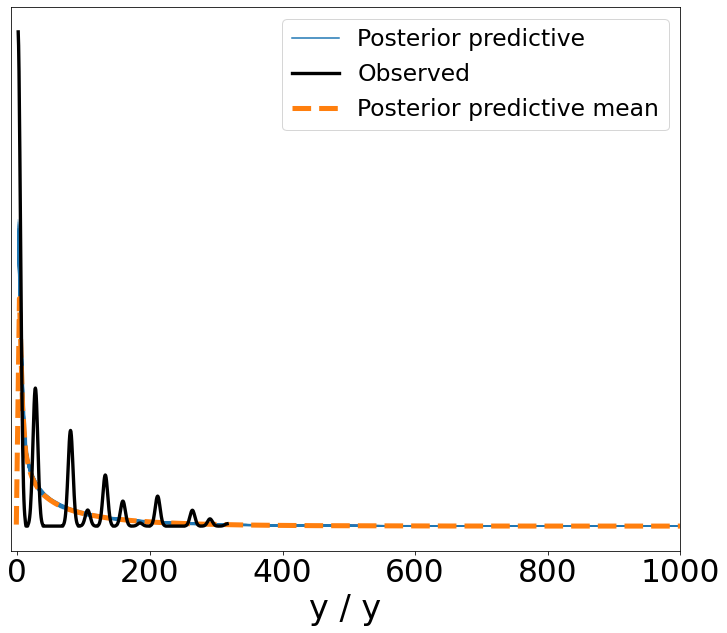

In [87]:
ax = az.plot_ppc(
    az.from_pymc3(posterior_predictive=ppc, model=model), figsize=(12, 10))
_ = ax.set_xlim((-10, 1000))

In [58]:
#generate sample from data just for testing
percent98 = survNoNA.carRiskScore.quantile(.98)
years = [2005, 2007, 2009]

In [99]:
#generate sample from data just for testing
for year in years:
    dat = survNoNA.query("carRiskScore < @percent98 & year == @year").sample(100)
    dat.loc[:,"carRiskScore"] = dat["carRiskScore"] + 1
    county_idxs, counties = pd.factorize(dat["sitecode"]) # needed for hierarchical model
    
    if year != 2005:
        counties = list(counties)
        newCountiesOrder, deletedCountiesIdx = [], []
        # finds the common counties from the previous years,
        # and what to add and delete
        i = 0
        for i, c in enumerate(coords["county"]):
            if c not in counties:
                deletedCountiesIdx.append(i)
            else:
                newCountiesOrder.append(c)
                counties.remove(c)
            i += 1
        
        newCountiesOrder += counties
        n = len(newCountiesOrder)
        # Updates the post dict to have the right number of counties, and for the new counties
        # it makes the starting point the betaN.
        for k in postDict.keys():
            if "County" in k:
                postDict[k] = [num for i,num in enumerate(postDict[k]) 
                                   if i not in deletedCountiesIdx]
                if "sig" in k:
                    postDict[k] += [postDict["ySig"]] * (n - len(postDict[k]))
                else:
                    postDict[k] += [postDict["beta"+k[10:]]] * (n - len(postDict[k]))
        
        counties = newCountiesOrder       
    coords = {
        "county": counties,
        "obs_id": np.arange(len(county_idxs)),
    }
    with pm.Model(coords=coords) as model:  # model specifications in PyMC3 are wrapped in a with-statement
        
        county_idx = pm.Data("county_idx", county_idxs, dims="obs_id")
    
        # Data Setup
        X = dat.drop(["carRiskScore", "sitecode"], axis=1)
        X.insert(0, "intercept", 1)
        
        # Defining betas for mu
        mu_est = 0
        for i, q in enumerate(X.columns):
            countyLevel = pm.Normal("betaCounty" + str(i), 1, sigma=10, dims="county")
            q_beta = pm.Normal("beta" + str(i), 1, sigma=10)
            mu_est += (q_beta + countyLevel[county_idx]) * X.iloc[:,i]
        
        # Defining Random Sigma
        countyLevel = pm.Normal("sigCounty", 1, sigma=10, dims="county")
        ySig = pm.Gamma("ySig", mu=100, sigma=1000)
        
        # Define likelihood
        likelihood = pm.Gamma(
            "y",
            mu=mu_est,
            sigma=(ySig + countyLevel[county_idx]),
            observed=dat["carRiskScore"], dims="obs_id")
        
    if year == 2005:
        with model:
            approx = pm.fit(1000)
    with model:
        if year == 2005:
            trace = pm.sample(100, return_inferencedata=True, target_accept=0.9, start=approx.sample()[0])
        else:
            trace = pm.sample(1, return_inferencedata=True, target_accept=0.9, start=postDict)
    
    with open('trace'+str(year)+'.pickle', 'wb') as handle:
        pickle.dump(trace, handle, protocol=pickle.HIGHEST_PROTOCOL)
    break
    # (n_jobs, n samples, num of hierarchies)
    postDict = trace.to_dict()["posterior"]
    for k in postDict.keys():
        postDict[k] = postDict[k].mean(axis=0).mean(axis=0)

Finished [100%]: Average Loss = 1.8615e+06
/tmp/ipykernel_413/923589532.py:70: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(100, return_inferencedata=True, target_accept=0.9, start=approx.sample()[0])
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ySig, sigCounty, beta17, betaCounty17, beta16, betaCounty16, beta15, betaCounty15, beta14, betaCounty14, beta13, betaCounty13, beta12, betaCounty12, beta11, betaCounty11, beta10, betaCounty10, beta9, betaCounty9, beta8, betaCounty8, beta7, betaCounty7, beta6, betaCounty6, beta5, betaCounty5, beta4, betaCounty4, beta3, betaCounty3, beta2, betaCounty2, beta1, betaCounty1, beta0, betaCounty0]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 239 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.7319296259216407, but should be close to 0.9. Try to increase the number of tuning steps.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.6317634496115005, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [101]:
with open('trace2005.pickle', 'rb') as handle:
    test = pickle.load(handle)
test  

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [100]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [114]:
def imputeMedian(dat):
    medians = dat.median().to_dict()
    return dat.fillna(value=medians)
#survSomeNA.groupby(["year"]).apply(imputeMedian).reset_index(drop=True).to_csv(root+"medianImputeOnYear.csv")
#survSomeNA.groupby(["year", "sitecode"]).apply(imputeMedian).reset_index(drop=True).to_csv(root+"medianImputeOnYearAndSite.csv")

/tmp/ipykernel_413/1042336991.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  medians = dat.median().to_dict()


In [4]:
survNoNA

,carRiskScore,sitecode,year,age,sex,grade,race4,race7,stheight,stweight,bmi,qnobese,qnowt,q13,q18,q25,q26,q47,q57
122833,78.947368,CH,2005,1.0,2.0,1.0,2.0,3.0,1.80,72.58,22.401235,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
122834,0.000000,CH,2005,3.0,2.0,1.0,2.0,3.0,1.96,113.40,29.518950,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
122836,105.263158,CH,2005,3.0,2.0,1.0,2.0,3.0,1.78,60.33,19.041156,2.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0
122839,157.894737,CH,2005,3.0,2.0,1.0,2.0,3.0,1.78,61.69,19.470395,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0
122840,0.000000,CH,2005,3.0,2.0,1.0,4.0,7.0,1.78,69.85,22.045828,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492474,131.578947,ST,2019,7.0,1.0,3.0,2.0,3.0,1.63,86.18,32.436298,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
492477,0.000000,ST,2019,7.0,1.0,4.0,2.0,3.0,1.50,45.36,20.160000,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0
492480,78.947368,ST,2019,7.0,1.0,4.0,2.0,3.0,1.55,97.52,40.591051,1.0,2.0,1.0,1.0,1.0,2.0,6.0,1.0
492481,26.315789,ST,2019,7.0,1.0,4.0,2.0,3.0,1.60,110.68,43.234375,1.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0


# Running Bambi Model
[back to top](#Table-of-Contents)

In [20]:
qsAdd = "+".join(survNoNA.drop(['carRiskScore', 'sitecode', 'year',
                                'age', 'sex', 'grade', 'race4',
                                'bmi', 'qnowt'],axis=1).columns)
formula = 'carRiskScore ~ (1|sitecode) + age + C(sex) + C(grade) + C(race4) + bmi + C(qnowt) +' + qsAdd

In [8]:
# Dropping over 98% and getting 2017
percent98 = survNoNA.carRiskScore.quantile(.98)
dat = survNoNA.query("carRiskScore < @percent98 & year == 2017")
# adding one because asymptote at 0
dat.loc[:, "carRiskScore"] = dat.loc[:, "carRiskScore"] + 1

# modeling with bambi
model_gamma = Model(formula, dat, family="gamma", link="log")
fitted_gamma = model_gamma.fit(tune=2000, target_accept=0.9)

/home/berlands/anaconda3/envs/STATS507/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/berlands/anaconda3/envs/STATS507/lib/python3.9/site-packages/pandas/core/frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [carRiskScore_alpha, 1|sitecode_of

/home/berlands/anaconda3/envs/STATS507/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:220: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/home/berlands/anaconda3/envs/STATS507/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:199: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)

The default initialization using init='auto' has failed, trying to recover by switching to init='adapt_diag'
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [carRiskScore_alpha, 1|sitecode_offset, 1|sitecode_sigma, bmi, C(race7), C(grade), C(sex), age, Intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 734 seconds.


In [21]:
qsAdd = "+".join(surv2017.drop(['carRiskScore', 'sitecode', 'year',
                                'age', 'sex', 'grade', 'race4',
                                'bmi', 'qnowt'],axis=1).columns)
formulaImput = 'carRiskScore ~ (1|sitecode) + age + C(sex) + C(grade) + C(race4) + bmi + C(qnowt) +' + qsAdd

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'C(sex)'}>,
        <AxesSubplot:title={'center':'C(sex)'}>],
       [<AxesSubplot:title={'center':'C(grade)'}>,
        <AxesSubplot:title={'center':'C(grade)'}>],
       [<AxesSubplot:title={'center':'C(race7)'}>,
        <AxesSubplot:title={'center':'C(race7)'}>],
       [<AxesSubplot:title={'center':'bmi'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'1|sitecode_sigma'}>,
        <AxesSubplot:title={'center':'1|sitecode_sigma'}>],
       [<AxesSubplot:title={'center':'1|sitecode'}>,
        <AxesSubplot:title={'center':'1|sitecode'}>],
       [<AxesSubplot:title={'center':'carRiskScore_alpha'}>,
        <AxesSubplot:title={'center':'carRiskScore_alpha'}>]],
      dtype=object)

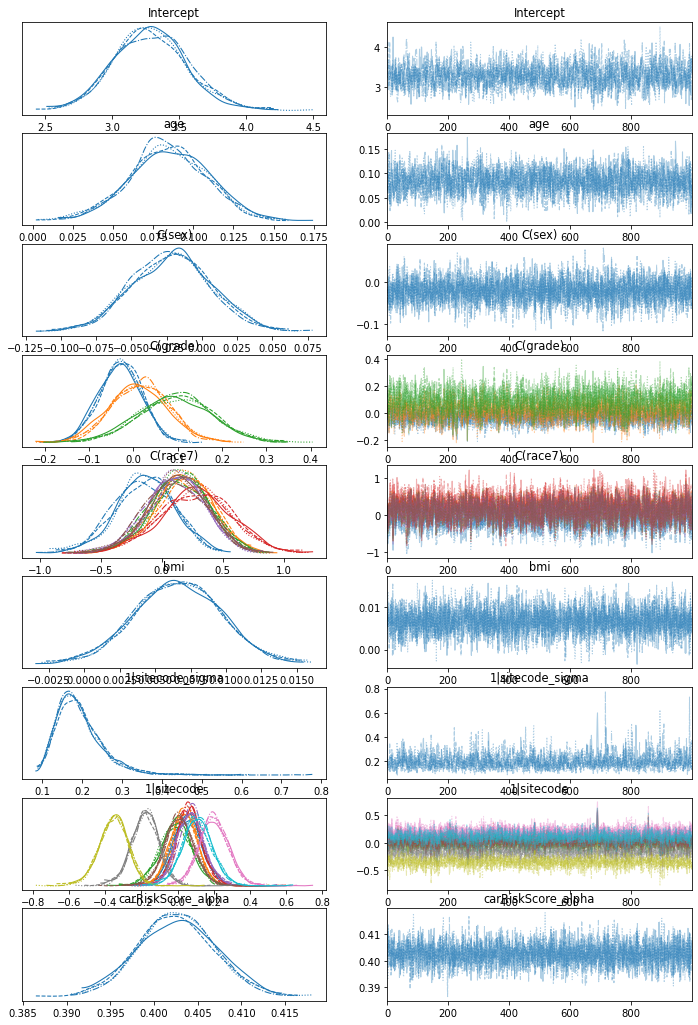

In [9]:
# Dropping over 98% and getting 2017
dat = surv2017.query("carRiskScore < @percent98")
# adding one because asymptote at 0
dat.loc[:, "carRiskScore"] = dat.loc[:, "carRiskScore"] + 1

# modeling with bambi
model_gamma = Model(formulaImput, dat, family="gamma", link="log")
fitted_gamma = model_gamma.fit(tune=2000, target_accept=0.9)

In [12]:
import bambi as bm

In [59]:
1/(survNoNA.carRiskScore + 1)

122833    0.012508
122834    1.000000
122836    0.009411
122839    0.006293
122840    1.000000
            ...   
492474    0.007543
492477    1.000000
492480    0.012508
492481    0.036609
492485    1.000000
Name: carRiskScore, Length: 108151, dtype: float64

In [15]:
bm.priors.PriorScaler(model_gamma)

In [16]:
model_gamma

Formula: carRiskScore ~ (1|sitecode) + age + C(sex) + C(grade) + C(race7) + bmi
Family name: Gamma
Link: log
Observations: 1000
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 17.5237)
    age ~ Normal(mu: 0.0, sigma: 2.1368)
    C(sex) ~ Normal(mu: 0.0, sigma: 5.0669)
    C(grade) ~ Normal(mu: [0. 0. 0.], sigma: [5.5864 5.6854 6.6711])
    C(race7) ~ Normal(mu: [0. 0. 0. 0. 0. 0.], sigma: [ 9.6716  5.4451  5.1505 29.9859  6.1595 16.6774])
    bmi ~ Normal(mu: 0.0, sigma: 0.5712)

  Group-level effects
    1|sitecode ~ Normal(mu: 0, sigma: HalfNormal(sigma: 17.5237))

  Auxiliary parameters
    alpha ~ HalfCauchy(beta: 1)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()